In [29]:
import torch
import numpy as np
import matplotlib.pyplot as plt
torch.set_default_dtype(torch.double)
from botorch.utils.sampling import draw_sobol_samples
from torchcubicspline import natural_cubic_spline_coeffs, NaturalCubicSpline

In [30]:
def gold_dielectric_function(x):
    wl = 1239.19/torch.tensor([0.1,0.2,0.3,0.4,0.5,0.5450000,0.5910000,0.6360000,0.64,0.77,0.89,
                           1.02,1.14,1.26,1.39,1.51,1.64,1.76,1.88,2.01,2.13,2.26,2.38,2.50,
                           2.63,2.75,2.88,3.00,3.12,3.25,3.37,3.50,3.62,3.74,3.87,3.99,4.12,
                           4.24,4.36,4.49,4.61,4.74,4.86,4.98,5.11,5.23,5.36,5.48,5.60])
    n_real = torch.tensor([25.17233,7.60352,3.53258,2.02586,1.299091,1.097350,0.9394755,
                       0.8141369,0.92,0.56,0.43,0.35,0.27,0.22,0.17,0.16,0.14,0.13,0.14,
                       0.21,0.29,0.43,0.62,1.04,1.31,1.38,1.45,1.46,1.47,1.46,1.48,1.50,
                       1.48,1.48,1.54,1.53,1.53,1.49,1.47,1.43,1.38,1.35,1.33,1.33,
                       1.32,1.32,1.30,1.31,1.30])
    n_imag = torch.tensor([77.92804,43.34848,29.52751,22.25181,17.77038,16.24777,
                       14.94747,13.82771,13.78,11.21,9.519,8.145,7.15,6.35,5.66,
                       5.08,4.542,4.103,3.697,3.272,2.863,2.455,2.081,1.833,1.849,
                       1.914,1.948,1.958,1.952,1.933,1.895,1.866,1.871,1.883,1.898,
                       1.893,1.889,1.878,1.869,1.847,1.803,1.749,1.688,1.631,1.577,
                       1.536,1.497,1.460,1.427])
    n_r = NaturalCubicSpline(natural_cubic_spline_coeffs(torch.flip(wl, [0]), torch.flip(n_real, [0]).reshape(-1,1)))
    n_i = NaturalCubicSpline(natural_cubic_spline_coeffs(torch.flip(wl, [0]), torch.flip(n_imag, [0]).reshape(-1,1)))
    eps = (n_r.evaluate(x) + 1j*n_i.evaluate(x))**2
   
    return eps.real, eps.imag

In [104]:
def sphere_extinction(wavelength, radius_mu, radius_sigma, em):
    e1, e2 = gold_dielectric_function(wavelength)
    e = torch.complex(e1, e2)

    factor = (e-em)/(e+2*em)
    radius = torch.distributions.Normal(radius_mu, radius_sigma)
    gamma = 0.0
    n_samples = 128
    radius_samples = radius.rsample((n_samples, ))
    for ri in radius_samples:
        scale = (4 * np.pi * (ri**1.5)) / (3 * wavelength)
        gamma += scale*factor.imag

    return gamma/n_samples 

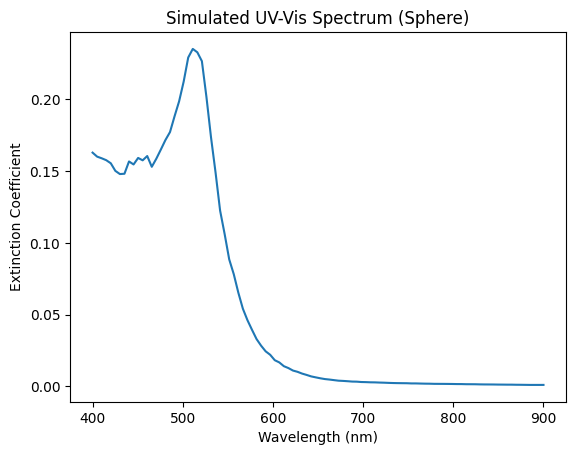

In [105]:
radius_mu = torch.Tensor([8.0])
radius_sigma = torch.Tensor([1.0])
em = torch.Tensor([1.33])
wavelengths = torch.linspace(400, 900, 100)
spectra_sphere = torch.zeros_like(wavelengths)
for i, wl in enumerate(wavelengths):
    spectra_sphere[i] = sphere_extinction(wl, radius_mu, radius_sigma, em)

plt.plot(wavelengths, spectra_sphere.detach().numpy())
plt.xlabel("Wavelength (nm)")
plt.ylabel("Extinction Coefficient")
plt.title("Simulated UV-Vis Spectrum (Sphere)")
plt.show()

In [108]:
def nanorod_extinction(wavelength, length_mu, length_sigma, radius_mu, radius_sigma, em):
    radius = torch.distributions.Normal(radius_mu, radius_sigma)
    length = torch.distributions.Normal(length_mu, length_sigma)
    n_samples = 128
    radius_samples = radius.rsample((n_samples, ))
    length_samples = length.rsample((n_samples, ))
    ext = 0.0
    e1, e2 = gold_dielectric_function(wavelength)
    scale = (2 * np.pi * (em**1.5)) / (3 * wavelength)
    for li, ri in zip(length_samples, radius_samples):
        ar = li/ri
        e = torch.sqrt(1 - (1 / ar)**2)
        PA = ( (1 - e**2)/ e**2 ) * ( ((1/ (2 * e)) * torch.log((1 + e) / (1 - e))) - 1 )
        PB = 0.5 * (1 - PA) 
        PC = 0.5 * (1 - PA)
        gamma = 0.0
        for P in [PA, PB, PC]:
            gj = (e2/ (P**2) )/( ( e1 + (((1-P)/P)*em) )**2 + e2**2)
            gamma += gj

        ext += scale*gamma

    return ext/n_samples    

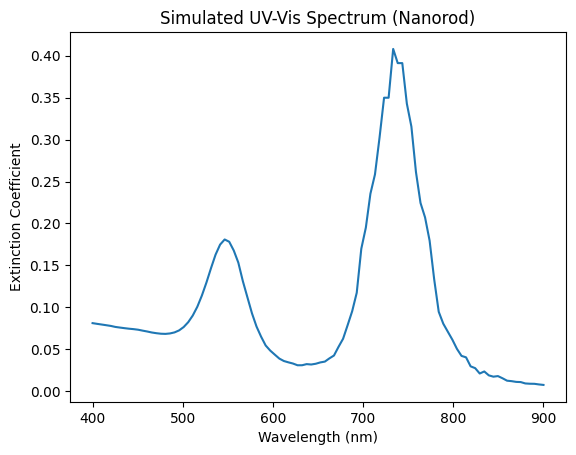

In [109]:
length_mu = torch.Tensor([40.0])
length_sigma = torch.Tensor([1.0])
radius_mu = torch.Tensor([20.0])
radius_sigma = torch.Tensor([1.0])
em = torch.Tensor([4.0])
wavelengths = torch.linspace(400, 900, 100)
spectra_nanorod = torch.zeros_like(wavelengths)
for i, wl in enumerate(wavelengths):
    spectra_nanorod[i] = nanorod_extinction(wl, length_mu, length_sigma, radius_mu, radius_sigma, em)

plt.plot(wavelengths, spectra_nanorod.detach().numpy())
plt.xlabel("Wavelength (nm)")
plt.ylabel("Extinction Coefficient")
plt.title("Simulated UV-Vis Spectrum (Nanorod)")
plt.show()

In [113]:
def objective_sphere(x):
    error = 0.0
    for i, wl in enumerate(wavelengths):
        s_query = sphere_extinction(wl, x[0], x[1], x[2])
        error += (s_query-spectra_sphere[i])**2
        
    return error

design_space_bounds = [(2.0, 20.0), # sphere radius (mu)
                       (0.5, 2.0), # sphere radius (sigma)
                       (1.0, 1.5), # dieletric constant for sphereical medium
                       ]

In [116]:
def objective_nanorod(x):
    error = 0.0
    s_query = torch.zeros_like(wavelengths)
    for i, wl in enumerate(wavelengths):
        s_query[i] = nanorod_extinction(wl, *x)
    error = (s_query-spectra_nanorod)**2 
           
    return error.sum()


design_space_bounds = [(20.0, 60.0), # nanorod length (mu)
                       (0.001, 2.0), # nanorod length (sigma)
                       (20.0, 40.0), # nanorod radius (mu)
                       (0.001, 1.0), # nanorod radius (sigma)
                       (2.0, 5.0), # dieletric constant for sphereical medium
                       ]


In [117]:
TRAINING_ITERATIONS = 100
NUM_RESTARTS = 10

best_error = np.inf 
for i in range(NUM_RESTARTS):
    bounds = torch.tensor(design_space_bounds).transpose(-1, -2)
    X = draw_sobol_samples(bounds=bounds, n=1, q=1).squeeze()
    X.requires_grad_(True)
    optimizer = torch.optim.Adam([X], lr=0.01)
    print("Run %d/%d"%(i, NUM_RESTARTS))
    
    for j in range(TRAINING_ITERATIONS):
        optimizer.zero_grad()
        loss = objective_nanorod(X)
        loss.backward() 
        optimizer.step()

        # clamp values to the feasible set
        for k, (lb, ub) in enumerate(zip(*bounds)):
            X.data[..., k].clamp_(lb, ub) 

        if loss.item()<1e-2:
            break
        if (j + 1) % 10 == 0:
            print(f"Iteration {j+1:>3}/{TRAINING_ITERATIONS:>3} - Loss: {loss.item():>4.3f}; dX: {X.grad.squeeze()}")

    if loss.item()<best_error:
        best_error = loss.item()
        best_X = X.clone().detach()

    if best_error<1e-2:
        break
    

Run 0/10
Iteration  10/100 - Loss: 1.386; dX: tensor([-0.2331, -0.2491,  0.5287, -0.0621, -3.1426])
Iteration  20/100 - Loss: 0.926; dX: tensor([-0.2403, -0.2267,  0.5497, -0.2187, -3.1050])
Iteration  30/100 - Loss: 0.516; dX: tensor([-0.2230, -0.1589,  0.5116, -0.1929, -2.7745])
Iteration  40/100 - Loss: 0.200; dX: tensor([-0.1468, -0.0904,  0.3391, -0.1328, -1.8106])
Iteration  50/100 - Loss: 0.075; dX: tensor([-0.0401, -0.0483,  0.0960, -0.0689, -0.5789])
Iteration  60/100 - Loss: 0.070; dX: tensor([ 0.0269, -0.0433, -0.0553, -0.0761,  0.1533])
Iteration  70/100 - Loss: 0.058; dX: tensor([ 0.0356, -0.0267, -0.0772, -0.0437,  0.2582])
Iteration  80/100 - Loss: 0.058; dX: tensor([ 0.0214, -0.0217, -0.0456, -0.0323,  0.1030])
Iteration  90/100 - Loss: 0.059; dX: tensor([ 0.0184, -0.0231, -0.0374, -0.0646,  0.0687])
Iteration 100/100 - Loss: 0.048; dX: tensor([ 0.0122, -0.0154, -0.0253, -0.0266,  0.0099])
Run 1/10


KeyboardInterrupt: 

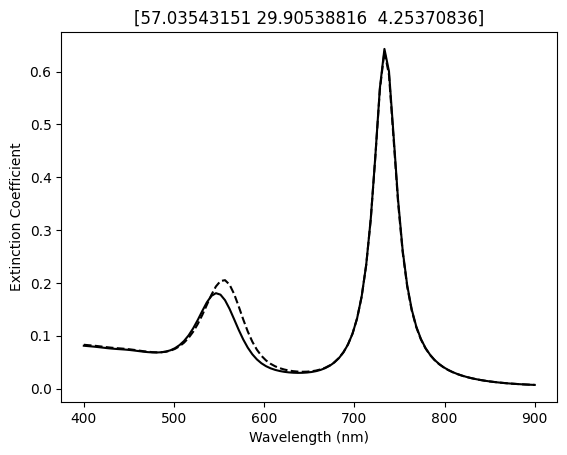

In [51]:
spectra_nanorod_optimized = torch.zeros_like(wavelengths)
for i, wl in enumerate(wavelengths):
    spectra_nanorod_optimized[i] = nanorod_extinction(wl, best_X[0], best_X[1], best_X[2])

fig, ax = plt.subplots()
ax.plot(wavelengths, spectra_nanorod.detach().numpy(), color="k")
ax.plot(wavelengths, spectra_nanorod_optimized.detach().numpy(), color="k", ls="--")
ax.set_xlabel("Wavelength (nm)")
ax.set_ylabel("Extinction Coefficient")
ax.set_title(X.detach().numpy())
plt.show()

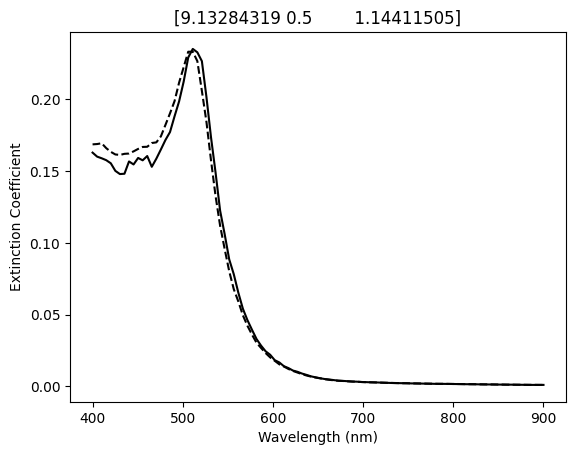

In [115]:
spectra_sphere_optimized = torch.zeros_like(wavelengths)
for i, wl in enumerate(wavelengths):
    spectra_sphere_optimized[i] = sphere_extinction(wl, best_X[0], best_X[1], best_X[2])

fig, ax = plt.subplots()
ax.plot(wavelengths, spectra_sphere.detach().numpy(), color="k")
ax.plot(wavelengths, spectra_sphere_optimized.detach().numpy(), color="k", ls="--")
ax.set_xlabel("Wavelength (nm)")
ax.set_ylabel("Extinction Coefficient")
ax.set_title(X.detach().numpy())
plt.show()